In [2]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [3]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [1]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [4]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///resources/hawaii.sqlite")

In [5]:
# reflect an existing database into a new model

Base = automap_base()
Base.prepare(engine, reflect=True)
# reflect the tables



In [6]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [7]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [8]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

In [10]:
#first create an inspector to get more detailed info
inspector = inspect(engine)
#then get column names for the relevant classes
columns = inspector.get_columns('measurement')
for column in columns:
    print(column["name"], column["type"])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [40]:
# Find the most recent date in the data set.
last_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
endDate = dt.date.fromisoformat(last_date[0])
endDate


datetime.date(2017, 8, 23)

<AxesSubplot:xlabel='Date', ylabel='Percipitaion (inch)'>

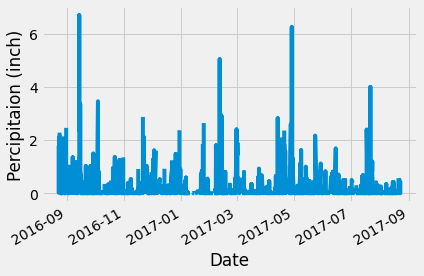

In [59]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 

# Calculate the date one year from the last date in data set.
# one year preveions means subtract one from year
begin_date = endDate - dt.timedelta(days=365)
begin_date
# Perform a query to retrieve the data and precipitation scores
oneYearData= session.query(Measurement).filter(Measurement.date >= begin_date).filter(Measurement.date <=endDate).all()
oneYearData
# Save the query results as a Pandas DataFrame and set the index to the date column
oneYearData_df = pd.read_sql(session.query(Measurement).filter(Measurement.date >= begin_date).filter(Measurement.date <=endDate).statement, session.bind)
oneYearData_df
# Sort the dataframe by date
oneYearData_df['date'] = pd.to_datetime(oneYearData_df['date'])
oneYearData_df = oneYearData_df.sort_values(by = 'date')
oneYearData_df
# Use Pandas Plotting with Matplotlib to plot the data
oneYearData_df.plot.line('date','prcp', xlabel= 'Date', ylabel='Percipitaion (inch)', legend=False)



In [62]:
# Use Pandas to calcualte the summary statistics for the precipitation data
oneYearData_df['prcp'].describe()


count    2021.000000
mean        0.177279
std         0.461190
min         0.000000
25%         0.000000
50%         0.020000
75%         0.130000
max         6.700000
Name: prcp, dtype: float64

# Exploratory Station Analysis

In [91]:
# Design a query to calculate the total number stations in the dataset
stations = session.query(func.count(Measurement.station.distinct())).all()
stations

[(9,)]

In [100]:
# Design a query to find the most active stations (i.e. what stations have the most rows?)
# List the stations and the counts in descending order.

station_activity = session.query(Measurement.station,func.count(Measurement.station)).group_by(Measurement.station).order_by(func.count(Measurement.station).desc()).all()
station_activity


[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [104]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
active_stats = session.query(func.min(Measurement.tobs),func.max(Measurement.tobs),func.avg(Measurement.tobs)).filter(Measurement.station=='USC00519281').all()
active_stats

[(54.0, 85.0, 71.66378066378067)]

AttributeError: 'Rectangle' object has no property 'xlabel'

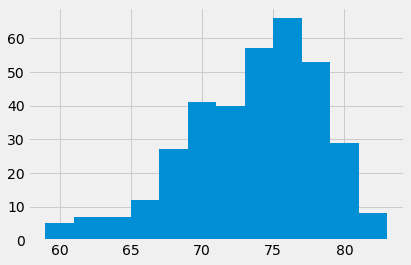

In [110]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram

active_stats = session.query(Measurement.tobs).filter(Measurement.station=='USC00519281').filter(Measurement.date >= begin_date).filter(Measurement.date <=endDate)

yearoftemps= pd.read_sql(session.query(Measurement.tobs,Measurement.date).filter(Measurement.station=='USC00519281').filter(Measurement.date >= begin_date).filter(Measurement.date <=endDate).statement, session.bind)

yearoftemps.hist('tobs',bins=12)



# Close session

In [111]:
# Close Session
session.close()